In [4]:
import numpy as np
from quantum_logical.error_channel import ErrorChannel
from quantum_logical.interaction import ConversionGainInteraction
from qutip import Qobj, basis, tensor
from qutip.operators import sigmaz
from qutip.metrics import fidelity
import matplotlib.pyplot as plt
import numpy as np
from qutip import rand_ket, fidelity
from tqdm import tqdm

In [5]:
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1|
initial_state = tensor([one_rho] * 2)

# # |00> + |01>
# initial_state = tensor([basis(2, 0), basis(2, 0)]) + tensor([basis(2, 0), basis(2, 1)])
# initial_state = initial_state * initial_state.dag()

# |10>
initial_state = tensor([basis(2, 1), basis(2, 0)])
initial_state = initial_state * initial_state.dag()

initial_state /= initial_state.norm()
initial_state = initial_state.full()
initial_state = Qobj(initial_state)
initial_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [6]:
gc, gg = np.pi / 2, 0
trotter_dt = 0.1
duration = 1.0
H = ConversionGainInteraction(gc, gg)
iswap = H.construct_U(t=duration)
iswap

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [7]:
expected_state = iswap * Qobj(initial_state, dims=iswap.dims) * iswap.dag()
expected_state = Qobj(expected_state, dims=initial_state.dims)
expected_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [8]:
class MultiQubitErrorChannel(ErrorChannel):
    """A class for error channels that can be applied to multi-qubit systems."""

    def __init__(self, chi, trotter_dt):
        """
        Initializes with given arrays of T1 and T2 times for each qubit, and a trotter step size.
        """
        self.N = 2
        self.chi = chi
        self.num_qubits = 2
        dims = 2**self.num_qubits
        self.trotter_dt = trotter_dt
        super().__init__(trotter_dt, dims)

    def _init_kraus_operators(self):
        """
        Creates the multi-qubit Kraus operators for the error channels.
        """
        zz = tensor(sigmaz(), sigmaz())
        return [(-1j * self.chi * zz * np.pi / 2 * self.trotter_dt).expm()]


noise_channel = MultiQubitErrorChannel(chi=0, trotter_dt=1.0)
new_state = noise_channel.apply_error_channel(
    initial_state, duration, unitary=iswap, use_rust=False
)
new_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [9]:
fidelity(new_state, expected_state)

1.0

In [10]:
initial_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

20it [00:27,  1.39s/it]


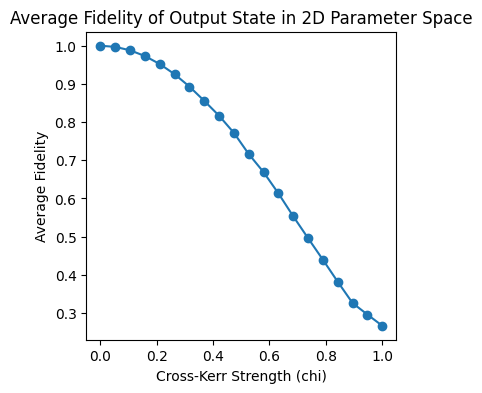

In [11]:
# Parameters
num_random_states = 1000  # Number of random states for Monte Carlo sampling
chi_values = np.linspace(0, 1, 20)  # Varying chi
average_fidelities = np.zeros(len(chi_values))

for i, chi in tqdm(enumerate(chi_values)):
    total_fidelity = 0
    noise_channel = MultiQubitErrorChannel(chi, trotter_dt)

    for _ in range(num_random_states):
        # Generate a random initial state
        random_initial_state = rand_ket(2**2)  # Adjust for the correct dimension
        random_initial_state = random_initial_state * random_initial_state.dag()

        # Apply the quantum operation
        new_state = noise_channel.apply_error_channel(
            random_initial_state, duration, unitary=iswap, use_rust=False
        )

        # Compute the expected state
        expected_state = (
            iswap * Qobj(random_initial_state, dims=iswap.dims) * iswap.dag()
        )
        expected_state = Qobj(expected_state, dims=random_initial_state.dims)

        # Calculate and accumulate fidelity
        total_fidelity += fidelity(new_state, expected_state)

    # Compute the average fidelity
    average_fidelities[i] = total_fidelity / num_random_states

# Plotting the results
plt.figure(figsize=(4, 4))
plt.plot(chi_values, average_fidelities, "o-")
plt.xlabel("Cross-Kerr Strength (chi)")
plt.ylabel("Average Fidelity")
plt.title("Average Fidelity of Output State in 2D Parameter Space")
plt.show()